In [180]:
import pandas as pd
import numpy as np

from sklearn.model_selection import *

from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [181]:
train=pd.read_csv('Untitled Folder/train.csv')
test=pd.read_csv('Untitled Folder/test.csv')


dict_stay={'0-10':0,'11-20':1, '21-30':2, '31-40':3, '41-50':4, '51-60':5, '61-70':6, '71-80':7,
        '81-90':8, '91-100':9, 'More than 100 Days':10}

train['Stay'].replace(dict_stay,inplace=True)
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,4
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,3
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,4
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,4


In [182]:
agg1=train.groupby(['Hospital_type_code','Department','Ward_Facility_Code','Bed Grade','Type of Admission','Severity of Illness','Age','Stay']).size().unstack().reset_index()
agg1.columns=['Hospital_type_code', 'Department','Ward_Facility_Code' ,'Bed Grade','Type of Admission', 'Severity of Illness','Age',
              's0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']

s_cols=['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
agg1['sum_']=agg1[s_cols].sum(axis=1)
for col in s_cols:
    agg1[col]=round(100*agg1[col]/agg1['sum_'],2)
agg1.drop(['sum_'],axis=1,inplace=True)
agg1.fillna(0,inplace=True)
agg1.head()

,Hospital_type_code,Department,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Age,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,a,TB & Chest disease,B,1.0,Emergency,Extreme,41-50,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a,TB & Chest disease,B,1.0,Emergency,Minor,51-60,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a,TB & Chest disease,B,1.0,Emergency,Minor,71-80,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a,TB & Chest disease,B,1.0,Emergency,Moderate,21-30,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a,TB & Chest disease,B,1.0,Emergency,Moderate,71-80,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
train=pd.merge(train,agg1,on=['Hospital_type_code','Department','Ward_Facility_Code','Bed Grade','Type of Admission','Severity of Illness','Age'],how='left')
test=pd.merge(test,agg1,on=['Hospital_type_code','Department','Ward_Facility_Code','Bed Grade','Type of Admission','Severity of Illness','Age'],how='left')

In [184]:
aggregations={\
               'case_id':'count',
               'Hospital_code':'nunique',
               'Hospital_type_code':'nunique',
               'City_Code_Hospital':'nunique',
               'Hospital_region_code':'nunique',
               'Department':'nunique',
               'Type of Admission':'nunique',
               'Admission_Deposit':'mean',
             }

patient_train=train.groupby(['patientid']).agg(aggregations)
patient_test=test.groupby(['patientid']).agg(aggregations)
                                

cols=['total_visits','uniqueHos','uniqueHosType','uniqueHosCity','uniqueHosRegion','uniqueDepartment','uniqueAdm','avgDeposit']
patient_train.columns=cols
patient_test.columns=cols

train=pd.merge(train,patient_train,on='patientid',how='left')
test=pd.merge(test,patient_test,on='patientid',how='left')

In [185]:
train_X=train.drop(['Stay'],axis=1)

train_X['type']='train'
test['type']='test'
data=pd.concat([train_X,test])

#fill na using group by
data['Bed Grade']=data.groupby(['Hospital_code'])['Bed Grade'].\
transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

data['City_Code_Patient']=data.groupby(['Hospital_region_code'])['City_Code_Patient'].\
transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

cat_col=['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code','Department', 'Ward_Type', 'Ward_Facility_Code',
       'City_Code_Patient', 'Type of Admission',
       'Severity of Illness','Age']

float_col=['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit',
          'total_visits','uniqueHos','uniqueHosType','uniqueHosCity','uniqueHosRegion','uniqueDepartment','uniqueAdm','avgDeposit','Bed Grade']

for col in cat_col:
    data[col]=le.fit_transform(data[col])

for col in float_col:
    data[col]=data[col].astype(float)

In [186]:
aggregations={\
               'case_id':'count',
               'patientid':'nunique' ,               
               'Department':'nunique',
               'Type of Admission':'nunique',
               'Admission_Deposit':'mean',
            }

hospital_data=data.groupby(['Hospital_code']).agg(aggregations)

cols=['h_cases','h_patient','h_dep','h_typeadm','h_avgdeposit']
hospital_data.columns=cols

data=pd.merge(data,hospital_data,on='Hospital_code',how='left')

data['hosp_deposit']=data.groupby(['Hospital_code','Department','Type of Admission','Severity of Illness'])['Admission_Deposit'].transform('mean')
data['per_dep_above_hosp']=100*(data['Admission_Deposit']-data['hosp_deposit'])/data['hosp_deposit']
data['per_dep_above_patient']=100*(data['Admission_Deposit']-data['avgDeposit'])/data['avgDeposit']
data.drop(['hosp_deposit'],axis=1,inplace=True)

In [187]:
train_X=data[data['type']=='train']
test_=data[data['type']=='test']
train_X.drop(['type'],axis=1,inplace=True)
test_.drop(['type'],axis=1,inplace=True)



X = train_X.drop(['case_id','patientid','City_Code_Hospital'],axis=1)
y = train['Stay']
test_=test_[X.columns]


cat_col=['Hospital_code','Hospital_type_code','Ward_Facility_Code',
       'Hospital_region_code','Department', 'Ward_Type',
       'City_Code_Patient', 'Type of Admission',
       'Severity of Illness','Age']

cat_cols=[X.columns.get_loc(c) for c in cat_col]

In [188]:
X.head()

,Hospital_code,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,total_visits,uniqueHos,uniqueHosType,uniqueHosCity,uniqueHosRegion,uniqueDepartment,uniqueAdm,avgDeposit,h_cases,h_patient,h_dep,h_typeadm,h_avgdeposit,per_dep_above_hosp,per_dep_above_patient
0,7,2,2,3.0,3,2,5,2.0,6,0,0,2.0,5,4911.0,20.0,0.00,60.00,20.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,5284,5114,5,3,4920.411809,6.304454,-17.476054
1,1,2,2,2.0,3,3,5,2.0,6,1,0,2.0,5,5954.0,0.0,0.00,13.33,46.67,6.67,13.33,0.00,20.0,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,7277,6134,5,3,4998.556685,20.087493,0.050412
2,9,4,0,2.0,1,3,4,2.0,6,1,0,2.0,5,4745.0,8.0,16.00,32.00,12.00,4.00,16.00,0.00,0.0,12.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,13538,12886,5,3,4556.475772,-4.804895,-20.265502
3,25,1,1,2.0,3,2,3,2.0,6,1,0,2.0,5,7272.0,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,48.723490,22.197950
4,25,1,1,2.0,3,3,3,2.0,6,1,0,2.0,5,5558.0,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,13.669576,-6.603932


In [189]:
clf_lgb = lgb.LGBMClassifier(boosting_type='gbdt', 
                      objective='multiclass',
                      num_class=11,
                      num_iteration=2000, 
                      
                      max_depth=7,
                      min_data_in_leaf=5,
                     
                      learning_rate=0.1,
                      categorical_feature = cat_cols,
                      random_state=101
                     )

In [190]:
X_temp=X.drop(['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10'],axis=1)
test_2=test_[X_temp.columns]

skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
cv_score = []
pred_test_lgb =np.zeros((len(test_),11))
pred_train =np.zeros((len(X_temp),11))

feat_imp=np.zeros((len(X_temp.columns),1))

for train_index,test_index in skf.split(X_temp,y):
    x_train,x_val = X_temp.iloc[train_index],X_temp.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    clf = clf_lgb
    clf.fit(x_train,y_train)
    score = round(accuracy_score(y_val,clf.predict(x_val)),2)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_train += clf.predict_proba(X_temp).reshape(-1,11)
    pred_test_lgb += clf.predict_proba(test_2).reshape(-1,11)
    feat_imp += clf.feature_importances_.reshape(-1,1)
    
pred_train=pred_train/10
pred_test_lgb = pred_test_lgb/10
feat_imp = feat_imp/10

feature_imp = pd.DataFrame(sorted(zip(X_temp.columns,feat_imp)), columns=['Feature','Value'])
feature_imp=feature_imp.sort_values(by='Value',ascending=False)

arg_pred_test=[]
for item in pred_test_lgb:
    arg_pred_test.append(np.argmax(item))
    
arg_pred_train=[]
for item in pred_train:
    arg_pred_train.append(np.argmax(item))
    
print(np.mean(cv_score))

0.43,0.43,0.43,0.43,0.43,0.43,0.43,

KeyboardInterrupt: 

In [ ]:
feature_imp

In [ ]:
sub=pd.DataFrame()
sub['Stay']=arg_pred_test
sub.index=test.case_id
sub=sub[['Stay']]
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
sub['Stay'].replace(inv_map_dict_stay,inplace=True)
sub.to_csv('try1.csv')
sub.head()

In [ ]:
df=pd.DataFrame()
df['Stay_original']=train.Stay
df['Stay_pred']=arg_pred_train
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
df['Stay_original'].replace(inv_map_dict_stay,inplace=True)
df['Stay_pred'].replace(inv_map_dict_stay,inplace=True)


pd.crosstab(df.Stay_original,df.Stay_pred)

In [166]:
opt=train.copy()
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
opt['Stay'].replace(inv_map_dict_stay,inplace=True)
opt=opt[opt['Stay'].isin(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30'])]
opt.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,total_visits,uniqueHos,uniqueHosType,uniqueHosCity,uniqueHosRegion,uniqueDepartment,uniqueAdm,avgDeposit
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,20.0,0.00,60.00,20.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,14,10,7,7,3,3,3,5951.0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,0.0,0.00,13.33,46.67,6.67,13.33,0.00,20.0,0.0,0.00,0.00,14,10,7,7,3,3,3,5951.0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,8.0,16.00,32.00,12.00,4.00,16.00,0.00,0.0,12.0,0.00,0.00,14,10,7,7,3,3,3,5951.0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14,10,7,7,3,3,3,5951.0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14,10,7,7,3,3,3,5951.0


In [167]:
opt['hosp_deposit']=opt.groupby(['Hospital_code','Department','Type of Admission','Severity of Illness'])['Admission_Deposit'].transform('mean')
opt['per_dep_above_hosp']=100*(opt['Admission_Deposit']-opt['hosp_deposit'])/opt['hosp_deposit']
opt['per_dep_above_patient']=100*(opt['Admission_Deposit']-opt['avgDeposit'])/opt['avgDeposit']

In [168]:
opt.groupby(['Stay'])['per_dep_above_hosp'].describe()

,count,mean,std,min,25%,50%,75%,max
Stay,,,,,,,,
0-10,23604.0,-5.275475,21.108693,-66.106824,-19.139805,-7.287388,6.105584,115.408898
11-20,78139.0,0.631958,19.549712,-62.848709,-11.761959,-1.870673,10.011109,117.426303
21-30,87491.0,2.439019,19.792296,-64.396246,-9.980348,-0.200091,11.885047,133.088450
31-40,55159.0,-0.606393,21.382260,-62.018418,-14.473956,-3.709277,9.485166,137.093245
41-50,11743.0,-0.255735,22.449537,-61.404105,-13.739124,-1.765628,11.250754,132.505523
51-60,35018.0,-2.907056,23.032521,-62.940466,-17.754839,-7.252636,6.937525,137.625308


Stay
0-10     AxesSubplot(0.125,0.125;0.775x0.755)
11-20    AxesSubplot(0.125,0.125;0.775x0.755)
21-30    AxesSubplot(0.125,0.125;0.775x0.755)
31-40    AxesSubplot(0.125,0.125;0.775x0.755)
41-50    AxesSubplot(0.125,0.125;0.775x0.755)
51-60    AxesSubplot(0.125,0.125;0.775x0.755)
Name: per_dep_above_hosp, dtype: object

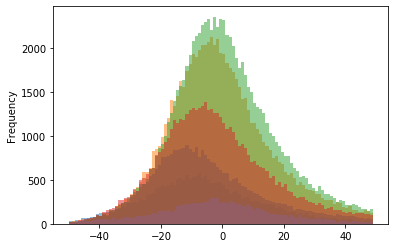

In [174]:
opt.groupby(['Stay'])['per_dep_above_hosp'].plot(kind='hist',bins=np.arange(-50,50,1),alpha=0.5)

In [46]:
train2=train_X.drop(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age'],axis=1)
test2=test_[train2.columns]


impute_median=SimpleImputer(missing_values=np.nan,strategy='mean')
s_col=['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7','s8', 's9', 's10']
for c in s_col:
    train2[c]=impute_median.fit_transform(train2[[c]]).ravel()
    test2[c]=impute_median.fit_transform(test2[[c]]).ravel()
train2.head()

,Admission_Deposit,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,total_visits,uniqueHos,uniqueHosType,uniqueHosCity,uniqueHosRegion,uniqueDepartment,uniqueAdm,avgDeposit,h_cases,h_patient,h_dep,h_typeadm,h_avgdeposit
0,4911.0,20.0,0.00,20.00,0.00,0.00,60.00,0.0,0.00,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,5284,5114,5,3,4920.411809
1,5954.0,0.0,6.67,46.67,0.00,13.33,13.33,20.0,0.00,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,7277,6134,5,3,4998.556685
2,4745.0,8.0,4.00,12.00,16.00,16.00,32.00,0.0,0.00,12.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,13538,12886,5,3,4556.475772
3,7272.0,0.0,13.16,21.05,21.05,13.16,23.68,0.0,2.63,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644
4,5558.0,0.0,13.16,21.05,21.05,13.16,23.68,0.0,2.63,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644


In [47]:
#Logistic Doesnt improve
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
# cv_score = []
# pred_test_log =np.zeros((len(test_),11))

# for train_index,test_index in skf.split(train2,y):
#     x_train,x_val = train2.iloc[train_index],train2.iloc[test_index]
#     y_train,y_val = y.iloc[train_index],y.iloc[test_index]
#     clf = LogisticRegression(C=1)
#     clf.fit(x_train,y_train)
#     score = round(accuracy_score(y_val,clf.predict(x_val)),2)
#     cv_score.append(score)
#     print(score,end=",")
    
#     #predictions
#     pred_test_log += clf.predict_proba(test2).reshape(-1,11)
    
# pred_test_log=pred_test_log/10

0.36,0.36,0.36,0.35,0.35,0.36,0.36,0.35,0.36,0.35,

In [26]:
def keras_model(input_dim=len(train2.columns)):
    model = Sequential()
    model.add(Dense(64, input_dim = input_dim , activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
    return model

skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
cv_score = []
pred_test_log =np.zeros((len(test_),11))
dummy_y = np_utils.to_categorical(y)

for train_index,test_index in skf.split(train2,y):
    x_train,x_val = train2.iloc[train_index],train2.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    
    y_train = np_utils.to_categorical(y_train)
    
    model=keras_model().fit(x_train, y_train, epochs = 500, batch_size = 1000)
    score = round(accuracy_score(y_val,model.model.predict_classes(x_val)),2)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_test_keras += model.model.predict_proba(test2).reshape(-1,11)
    
pred_test_keras=pred_test_keras/10

Epoch 1/500
286589/286589 [==============================] - 1s 4us/step - loss: 125.8858 - accuracy: 0.1908
Epoch 2/500
286589/286589 [==============================] - 1s 4us/step - loss: 37.5467 - accuracy: 0.1949
Epoch 3/500
286589/286589 [==============================] - 1s 4us/step - loss: 21.5674 - accuracy: 0.2004
Epoch 4/500
286589/286589 [==============================] - 1s 4us/step - loss: 15.6328 - accuracy: 0.2037
Epoch 5/500
286589/286589 [==============================] - 1s 4us/step - loss: 8.9822 - accuracy: 0.2100
Epoch 6/500
286589/286589 [==============================] - 1s 4us/step - loss: 7.0795 - accuracy: 0.2146
Epoch 7/500
286589/286589 [==============================] - 1s 4us/step - loss: 5.4388 - accuracy: 0.2225
Epoch 8/500
286589/286589 [==============================] - 1s 4us/step - loss: 4.7732 - accuracy: 0.2255
Epoch 9/500
286589/286589 [==============================] - 1s 4us/step - loss: 4.0897 - accuracy: 0.2324
Epoch 10/500
286589/286589 [====

286589/286589 [==============================] - 1s 4us/step - loss: 1.8713 - accuracy: 0.2772
Epoch 77/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8690 - accuracy: 0.2787
Epoch 78/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8652 - accuracy: 0.2784
Epoch 79/500
286589/286589 [==============================] - 2s 5us/step - loss: 1.8652 - accuracy: 0.2793
Epoch 80/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8701 - accuracy: 0.2779
Epoch 81/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.8686 - accuracy: 0.2778
Epoch 82/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8674 - accuracy: 0.2785
Epoch 83/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8759 - accuracy: 0.2782
Epoch 84/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.8643 - accuracy: 0.2788
Epoch 85/500
286589/286589 [=============

286589/286589 [==============================] - 1s 4us/step - loss: 1.7819 - accuracy: 0.3326
Epoch 152/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7812 - accuracy: 0.3316
Epoch 153/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7816 - accuracy: 0.3328
Epoch 154/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7806 - accuracy: 0.3327
Epoch 155/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7817 - accuracy: 0.3317
Epoch 156/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7810 - accuracy: 0.3325
Epoch 157/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7817 - accuracy: 0.3332
Epoch 158/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7845 - accuracy: 0.3317
Epoch 159/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7804 - accuracy: 0.3325
Epoch 160/500
286589/286589 [====

286589/286589 [==============================] - 1s 4us/step - loss: 1.7716 - accuracy: 0.3334
Epoch 227/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7721 - accuracy: 0.3332
Epoch 228/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7703 - accuracy: 0.3339
Epoch 229/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7686 - accuracy: 0.3342
Epoch 230/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7720 - accuracy: 0.3328
Epoch 231/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7693 - accuracy: 0.3347
Epoch 232/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7695 - accuracy: 0.3337
Epoch 233/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7727 - accuracy: 0.3333
Epoch 234/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7721 - accuracy: 0.3332
Epoch 235/500
286589/286589 [====

Epoch 301/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7708 - accuracy: 0.3329
Epoch 302/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7659 - accuracy: 0.3355
Epoch 303/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7689 - accuracy: 0.3340
Epoch 304/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7671 - accuracy: 0.3348
Epoch 305/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7765 - accuracy: 0.3288
Epoch 306/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7648 - accuracy: 0.3351
Epoch 307/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7676 - accuracy: 0.3349
Epoch 308/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7662 - accuracy: 0.3349
Epoch 309/500
286589/286589 [==============================] - 1s 5us/step - loss: 1.7662 - accuracy: 0.3343
Epoch 310/500
28658

286589/286589 [==============================] - 1s 4us/step - loss: 1.7628 - accuracy: 0.3345
Epoch 377/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7605 - accuracy: 0.3360
Epoch 378/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7632 - accuracy: 0.3360
Epoch 379/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7616 - accuracy: 0.3364
Epoch 380/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7675 - accuracy: 0.3324
Epoch 381/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7653 - accuracy: 0.3342
Epoch 382/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7611 - accuracy: 0.3361
Epoch 383/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7626 - accuracy: 0.3344
Epoch 384/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7667 - accuracy: 0.3347
Epoch 385/500
286589/286589 [====

286589/286589 [==============================] - 1s 4us/step - loss: 1.7198 - accuracy: 0.3538
Epoch 452/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7231 - accuracy: 0.3521
Epoch 453/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7201 - accuracy: 0.3536
Epoch 454/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7208 - accuracy: 0.3534
Epoch 455/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7182 - accuracy: 0.3537
Epoch 456/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7192 - accuracy: 0.3538
Epoch 457/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7185 - accuracy: 0.3535
Epoch 458/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7193 - accuracy: 0.3535
Epoch 459/500
286589/286589 [==============================] - 1s 4us/step - loss: 1.7211 - accuracy: 0.3528
Epoch 460/500
286589/286589 [====

AttributeError: 'History' object has no attribute 'predict_classes'

In [29]:
p=model.model.predict_classes(x_val)

In [31]:
y_val

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
round(accuracy_score(y_val,model.model.predict_classes(x_val)),2)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
pred_test_final=(pred_test_lgb+pred_test_keras)/2
arg_pred_final=[]
for item in pred_test_final:
    arg_pred_final.append(np.argmax(item))
    
sub=pd.DataFrame()
sub['Stay']=arg_pred_final
sub.index=test.case_id
sub=sub[['Stay']]
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
sub['Stay'].replace(inv_map_dict_stay,inplace=True)
sub.to_csv('try1.csv')
sub.head()

In [ ]:
# #grid search for best param
# kf = KFold(n_splits=5, shuffle=True, random_state=42).split(X,y)

# param_grid = {
#     'objective':'multiclass',
#     'num_class':[11],
#     'num_iteration':[1000],
#     'max_depth':[5,7],
#     'num_leaves': [30, 100],
#     'min_data_in_leaf': [5,10],
#     'learning_rate':[0.1],
#     }

# gsearch=GridSearchCV(estimator=clf_lgb,param_grid=param_grid,n_jobs=-1,verbose=0,return_train_score=True,cv=kf)

# lgb_model = gsearch.fit(X,y)
# print(lgb_model.best_params_, lgb_model.best_score_)

In [ ]:
# cat=CatBoostClassifier(iterations=1000,  
#                          learning_rate=0.1,
#                          loss_function='MultiClass',
#                          cat_features = cat_cols,
#                         verbose=False
#                         )

# x_train,x_test,y_train,y_test=train_test_split(X,y)
# clf=cat.fit(x_train,y_train)
# print(accuracy_score(y_test,clf.predict(x_test)))